# Replicating Results


### What is this?
This notebook provides step-by-step instructions for replicating the results for multi-adjustment

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

from IPython.display import display 
from itertools import permutations, combinations
from jinja2 import Template
import dateparser


from ohio.ext.numpy import pg_copy_to_table

Specify The Database, demo_col of interest, demo_values of interest and the procedure you wish to use for adjustment

In [5]:
database="san_jose_housing_triage"

In [6]:
working_schema, results_schema = "kit_bias_adj", "bias_results"

In [7]:
demo_col = "median_income"

In [8]:
demo_values = ["over55k", "under55k"]

## Getting Set Up

You will need a database with the following schemas:
- **public**: The raw data from donors choose as well as some tables with calculated features and intermediate modeling tables
- **model_metadata**: Information about the models we ran, such as model types and hyperparameters (models were run with `triage`, which generates this schema. In `triage` a "model group" specifies a type of model and associated hyperparameter values, while a "model" is an instantiation of a given model group on a specific temporal validation split). Note that this schema contains information on other model runs with this dataset, in addition to the run used for the current study of fairness-accuracy trade-offs.
- **test_results**: Validation set statistics and predictions for the models. Here, `test_results.predictions` contains project-level predicted scores from each model in the grid, while `test_results.evaluations` contains aggregated summary statistics for each model.
- **train_results**: Training set statistics for the models, including feature importances.
- **features**: Intermediate tables containing calculated features from the `triage` run.
- **bias_working**: Intermediate tables from the bias analysis, as well as the mapping table between projects and school poverty levels, `bias_working.entity_demos`.
- **bias_results_submitted**: Results of the fairness-accuracy trade-offs from the study as submitted (see below to use these to replicate the figures from the study).
- **bias_results**: Empty bias analysis results tables that will be populated by re-running the fairness adjustments (see below for instructions).


Finally, to connect to the database, you'll need a yaml file named `db_profile.yaml` in the same directory as this notebook with your connection info:
```yaml
host: {POSTGRES_HOST}
user: {POSTGRES_USER}
db: education_crowdfunding
pass: {POSTGRES_PASSWORD}
port: {POSTGRES_PORT}
```


In [9]:
with open('../../config/db_default_profile.yaml') as fd:
    config = yaml.full_load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgresql",
        host=config["host"],
        username=config["user"],
        database=database,
        password=config["pass"],
        port=config["port"],
    )
    engine_donors = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

/tmp/ipykernel_1683/2016600179.py:3: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  dburl = sqlalchemy.engine.url.URL(


Next, we define a helper function that will pull the results of the various strategies explored in the study. The table `model_adjustment_results_plevel` contains performance statistics for each model type we ran with and without adjusting for recall equity and `composite_results_plevel` contains performance statistics for a stategy that selects the best-performing model for each subgroup separately (we'll look at generating these tables from the raw modeling results as well below). The query below uses four different strategies to choose a model for each temporal validation split based on these performance statistics:

In [10]:
recall_combinations = []
for a, b in combinations(demo_values, 2):
    recall_combinations.append(f"recall_{a}_to_{b}")

In [11]:
metrics = ["frac", "min_score", "mean_score", "precision", "prevalence", "positive_prevalence", "positive_rate"]

In [12]:
def get_demo_combination_sql(method="base"):
    base_demo_combination_sql = ""
    for i, setting in enumerate(recall_combinations):
        base_demo_combination_sql = base_demo_combination_sql+"\n\t\t" + f"r.{method}_{setting} AS {setting},"

    for metric in metrics:
        for d in demo_values:
            base_demo_combination_sql = base_demo_combination_sql+"\n\t\t" + f"r.{method}_{metric}_{d} AS {metric}_{d},"
    return base_demo_combination_sql[:-1] # To ommit the last , 

In [20]:
def get_bias_results(engine, schema=f'{results_schema}', mg_table=f'model_adjustment_results_{demo_col}', table=f'model_adjustment_results_{demo_col}', self_adjustment=False):
    comparator = ">"
    if self_adjustment:
        comparator = "="
    sql1 = f"""
    WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {schema}.{mg_table}
  WHERE past_train_end_time = train_end_time
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    , multi_adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    ) -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ratio AS max_recall_ratio,"""
    sql2 = f"""
           FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Model selection on last time before adjustment, with adjustment applied
    SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,"""
    sql3 = f"""
        FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Model selection on last time after adjustment, with adjustment applied
    SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,"""
    
    sql4=f"""
    FROM {schema}.{table} r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time before multiple adjustment, with multiple adjustment applied
    SELECT 'Best Unadjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,"""
    
    sql5=f"""
    FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    
        UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Multi Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,"""

    sql6=f"""
    FROM {schema}.{table} r
    JOIN multi_adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,"""
    
    sql7=f"""
    FROM {schema}.{table} r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    ;
    """
    sql = sql1 + get_demo_combination_sql() + sql2 + get_demo_combination_sql("adj") + sql3 + \
    get_demo_combination_sql("adj") + sql4 + get_demo_combination_sql("multi_adj") + sql5 + \
    get_demo_combination_sql("multi_adj") + sql6 + get_demo_combination_sql("multi_adj") + sql7

    print(sql)
    
    ts_df = pd.read_sql(sql, engine)

    ts_df['dataset'] = 'Education Crowdfunding'

    
    ts_df['strategy'] = ts_df['strategy'].map({
        'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
        'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
        'Best Adjusted Metric - MultiAdjusted': 'MultiMitigated - Adj Seln.',
        'Best Multi Adjusted Metric - MultiAdjusted': 'MultiMitigated - MAdj Seln.',
        'Composite Model - Adjusted': 'Mitigated - Composite Model',
        'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.', 
        'Best Unadjusted Metric - MultiAdjusted': "MultiMitigated - Unadj. Model Seln."        
    })
    

    return ts_df

## Reproducing Figures from the Study

As a starting point, we can reproduce the figures from the study directly using the data in the `bias_results_submitted` schema:

In [22]:
ts_df3 = get_bias_results(engine_donors, schema=f'{results_schema}')
self_adjustment_df = get_bias_results(engine_donors, schema=f'{results_schema}', self_adjustment=True)
self_adjustment_df = self_adjustment_df[self_adjustment_df["strategy"] == "Mitigated - Single Model"]
self_adjustment_df["strategy"] = "Self Adjusted"
ts_df3 = ts_df3.append(self_adjustment_df, ignore_index=True)
print(ts_df3.columns)


    WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_results.model_adjustment_results_median_income
  WHERE past_train_end_time = train_end_time
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    , multi_adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    ) -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ra

/tmp/ipykernel_1683/996253090.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts_df3 = ts_df3.append(self_adjustment_df, ignore_index=True)


In [29]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
months_fmt = mdates.DateFormatter('%b %y')

In [30]:
def line_plot_over_time(y, y_label, ax=None, strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln."]):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]
    if strategies is None or len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker="o")#, ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [31]:
def delta_line_plot_over_time(y, y_label, ax=None, strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln."]):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]
    if strategies is None or len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    df = df.copy()
    df = df.sort_values(['strategy', 'train_end_time']) #sort by strategy and time
    df['lag_val'] = df.groupby('strategy')[y].shift(1) #group by strategy and shift val column by one row
    df['lag_val'] = df[y] - df['lag_val'] #subtract the shifted column from the original column
    sns.lineplot(data=df, x='train_end_time', y="lag_val", hue=hue, marker="o", ax=ax)

    ax.set_ylabel("Delta "+y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [32]:
def line_plots_over_time(ys, y_labels, ax=None, strategies=["Unmitigated", "Mitigated - Single Model"], df=None):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]    
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    markers = ["*", "o", "s", "^", "P"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    for i, y in enumerate(ys):
        y_label = y_labels[i]
        marker = markers[i]
        sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker=marker, ax=ax, label=y_label)
    ax.set_xlabel('Test Set Date', fontsize=14)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ax.get_legend()
    
    return ax

### Supplementary Figure 3
Comparing model precision (a) and disparity (b) metrics over time fordifferent model selection strategies in the Education Crowdfunding policy context.

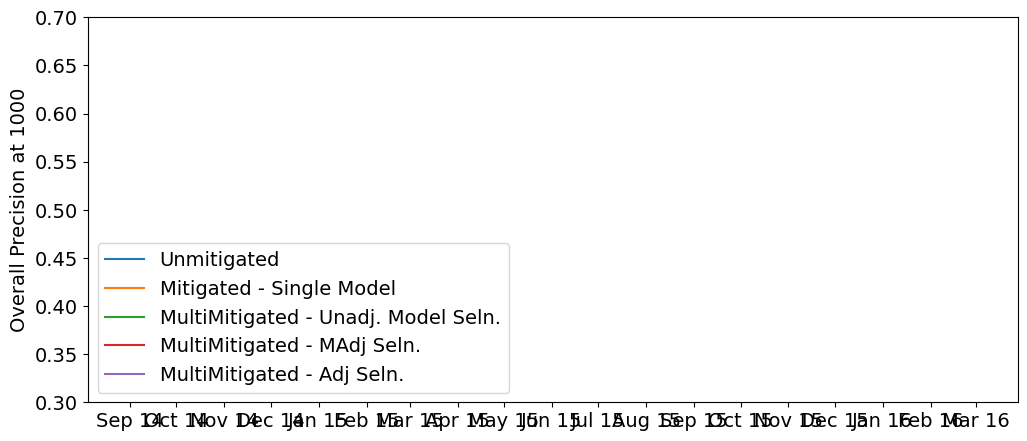

In [45]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[~ts_df3['strategy'].isin(['Mitigated - Unadj. Model Seln.', "Self Adjusted"]), ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14, loc='lower left')

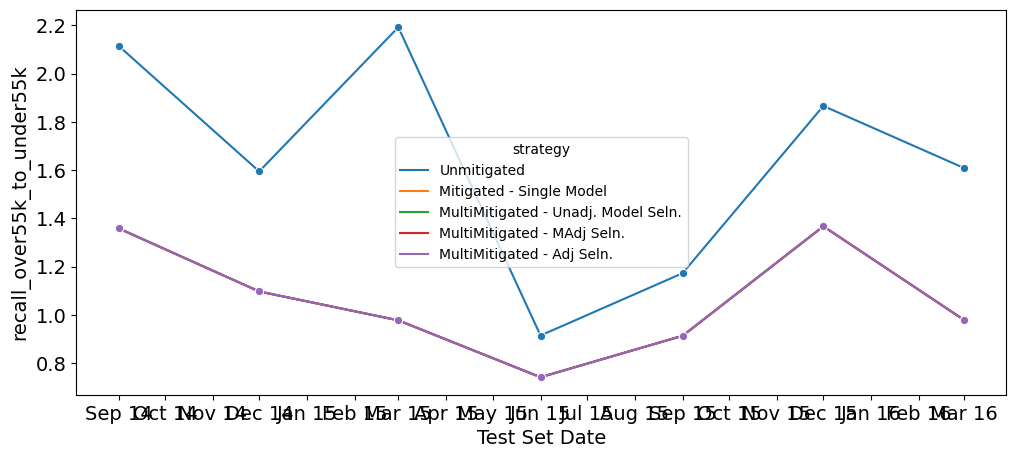

In [34]:
for setting in recall_combinations:
    line_plot_over_time(y=setting, y_label=f'{setting}')

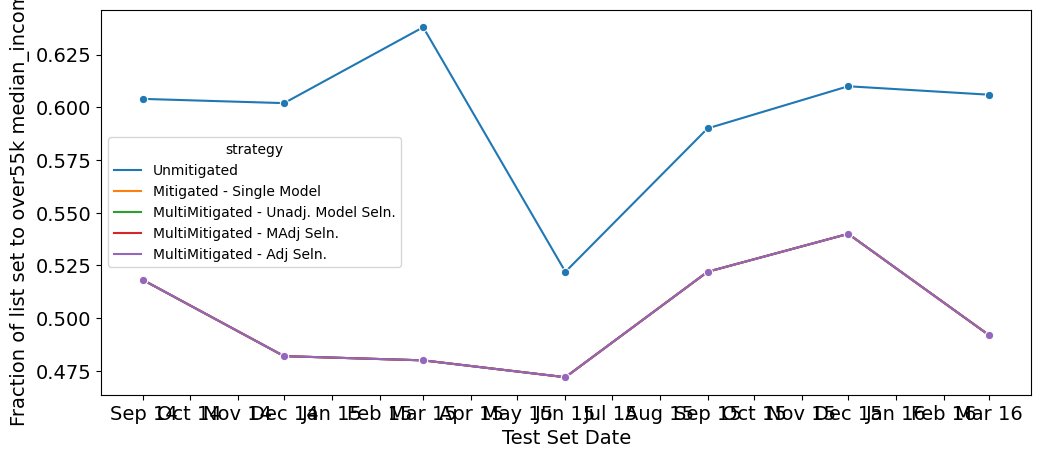

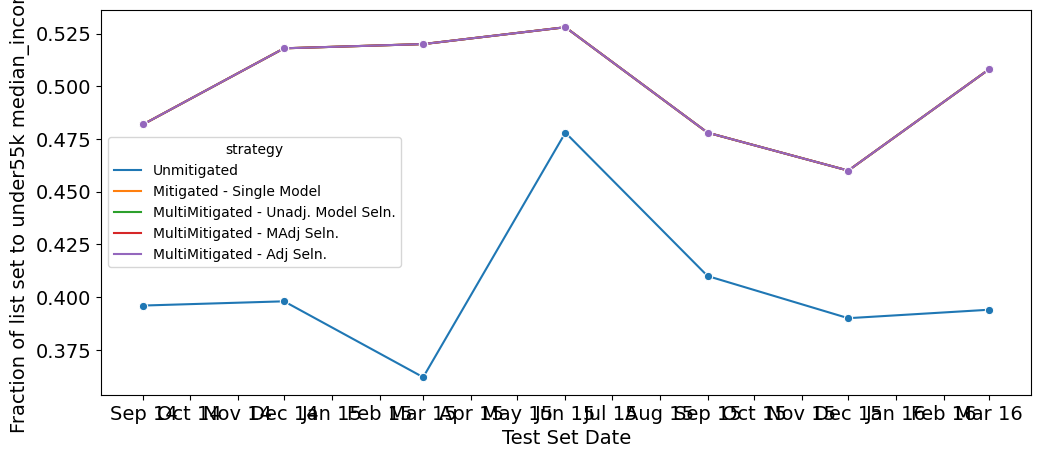

In [35]:
for cat in demo_values:
    line_plot_over_time(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}')

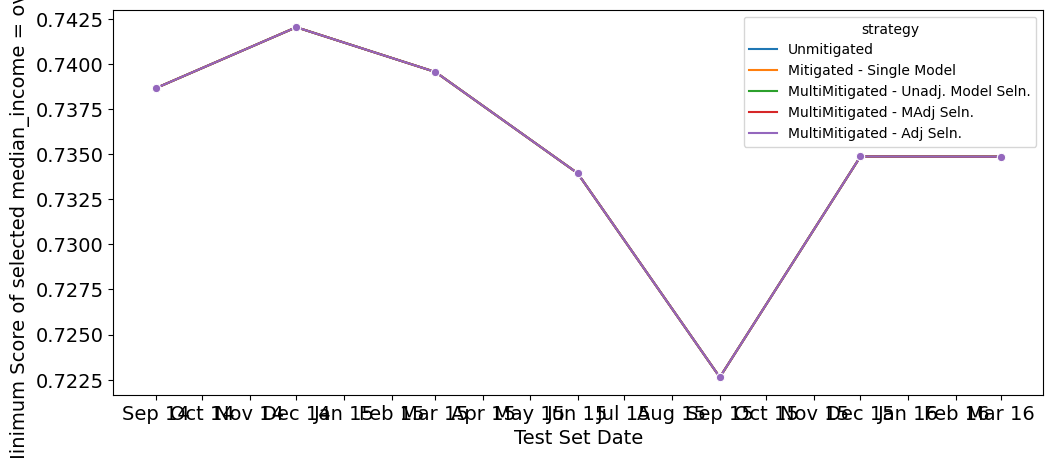

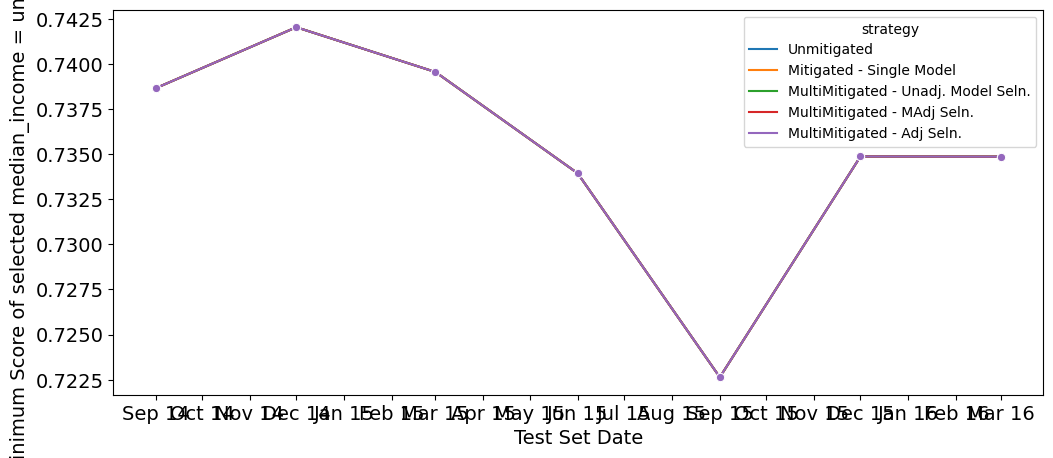

In [36]:
for cat in demo_values:
    line_plot_over_time(y=f"min_score_{cat}", y_label=f'Minimum Score of selected {demo_col} = {cat}')

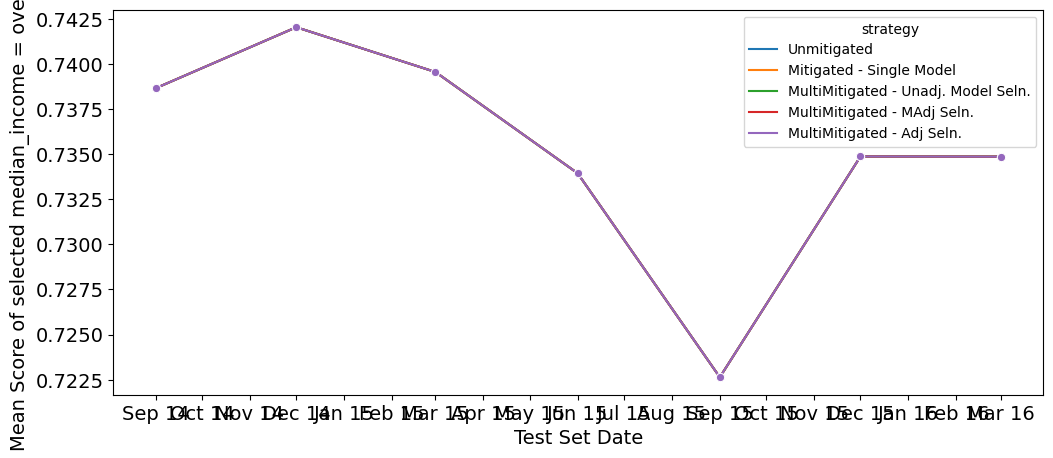

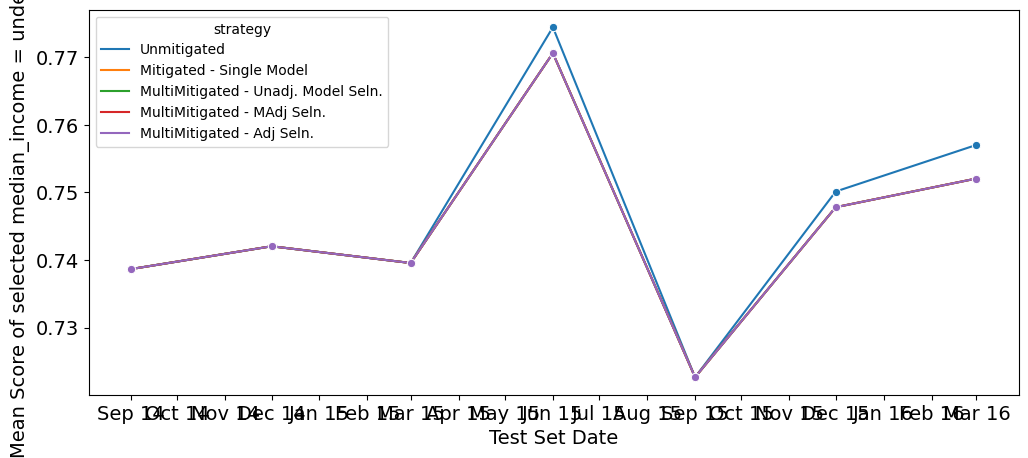

In [37]:
for cat in demo_values:
    line_plot_over_time(y=f"mean_score_{cat}", y_label=f'Mean Score of selected {demo_col} = {cat}')

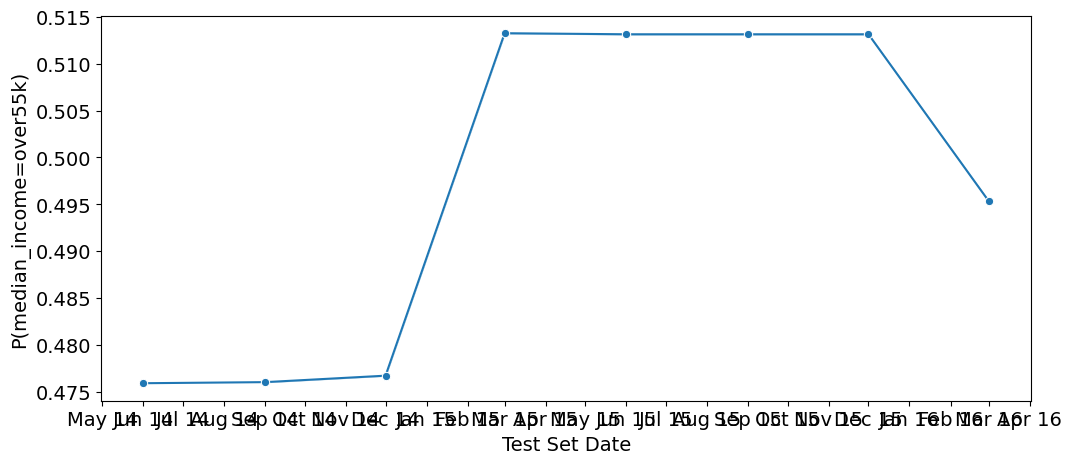

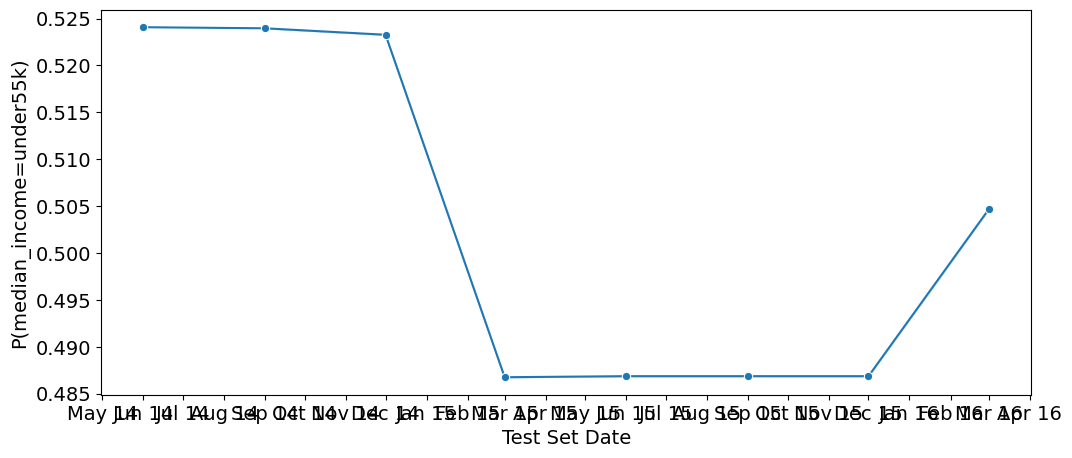

In [38]:
for cat in demo_values:
    line_plot_over_time(y=f"prevalence_{cat}", y_label=f'P({demo_col}={cat})', strategies=None)

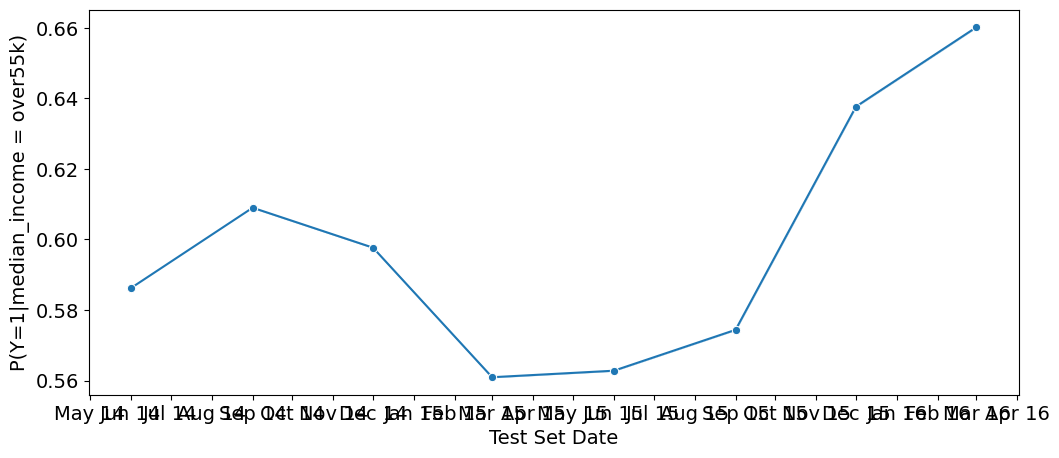

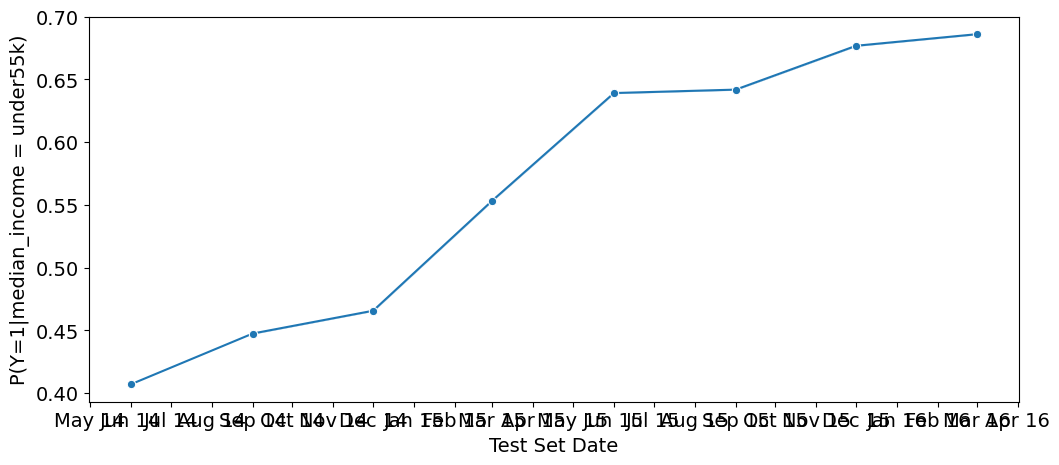

In [39]:
for cat in demo_values:
    line_plot_over_time(y=f"positive_rate_{cat}", y_label=f'P(Y=1|{demo_col} = {cat})', strategies=None)

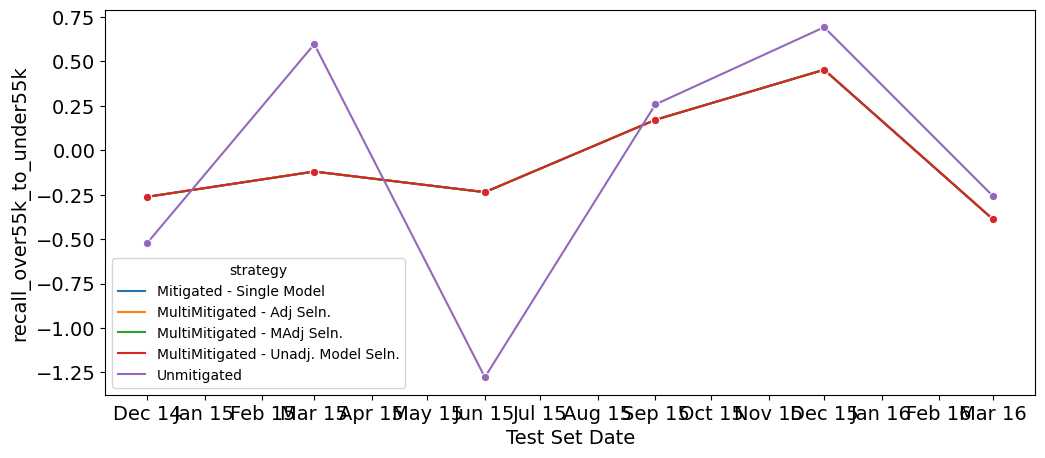

In [40]:
for setting in recall_combinations:
    delta_line_plot_over_time(y=setting, y_label=f'{setting}')

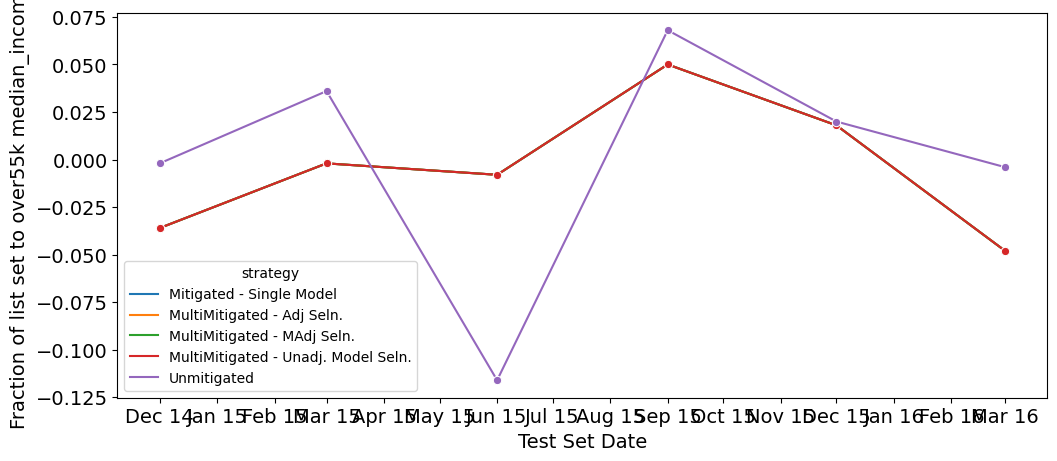

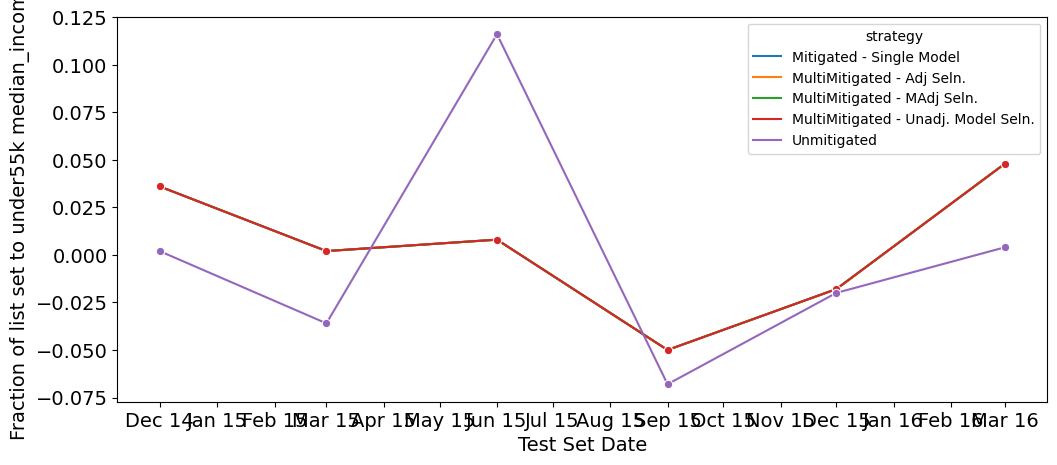

In [43]:
for cat in demo_values:
    delta_line_plot_over_time(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}')

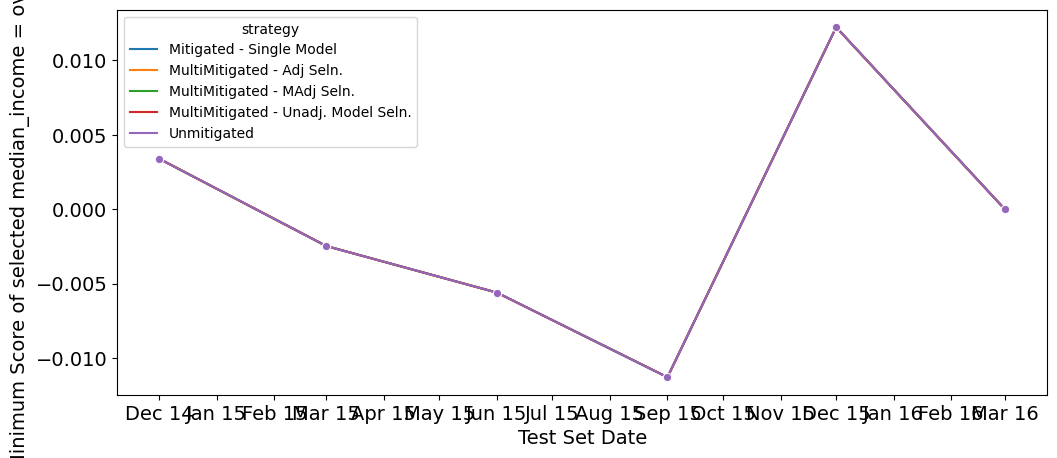

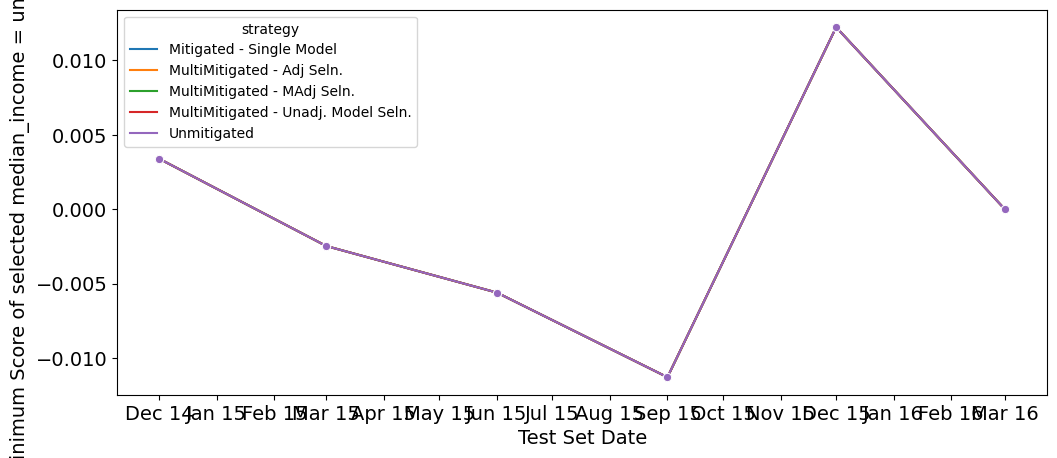

In [42]:
for cat in demo_values:
    delta_line_plot_over_time(y=f"min_score_{cat}", y_label=f'Minimum Score of selected {demo_col} = {cat}')

In [ ]:
for cat in demo_values:
    delta_line_plot_over_time(y=f"mean_score_{cat}", y_label=f'Mean Score of selected {demo_col} = {cat}')

In [ ]:
for cat in demo_values:
    delta_line_plot_over_time(y=f"prevalence_{cat}", y_label=f'P({demo_col}={cat})', strategies=None)

In [ ]:
for cat in demo_values:
    delta_line_plot_over_time(y=f"positive_rate_{cat}", y_label=f'P(Y=1|{demo_col} = {cat})', strategies=None)

### Figure 2 (Education Crowdfunding Points)
Comparing trade-offs across strategies

In [37]:
# renaming a few columns to ensure consistency across datasets
comp_df = ts_df3.rename(
    {f'recall_{demo_values[0]}_to_{demo_values[1]}': 'recall_disp', 
     f'frac_{demo_values[0]}': 'frac_grp1', 
     f'frac_{demo_values[1]}': 'frac_grp2'
    }, axis='columns')

/tmp/ipykernel_7013/2835087850.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),
/tmp/ipykernel_7013/2835087850.py:10: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),


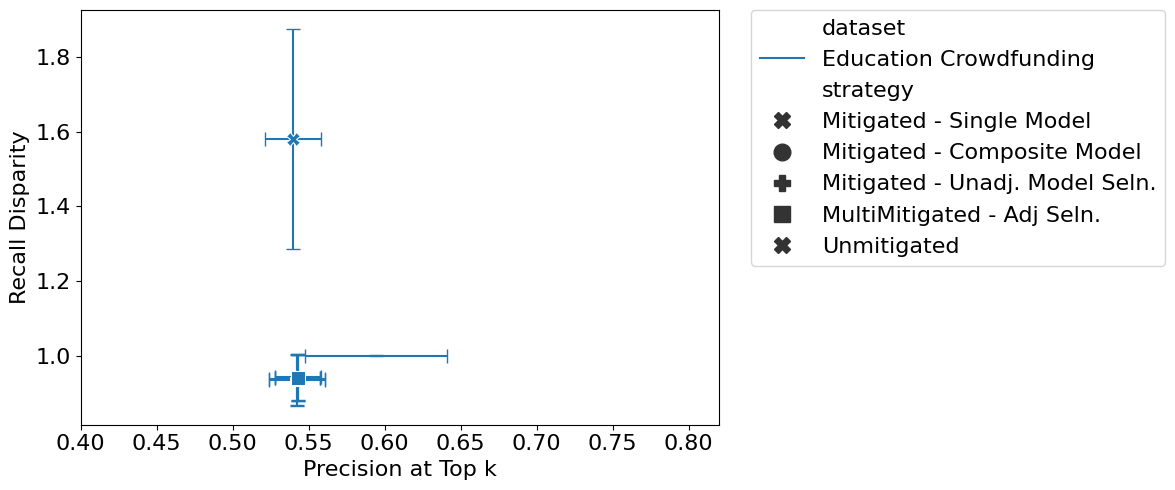

In [38]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'MultiMitigated - Adj Seln.', 
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
              style='strategy',
              style_order=sty_ord,
              markers=['X', 'o', 'P', 's'],
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

### Figure 3 (Education Crowdfunding Points)
Comparing trade-offs across weights of multimitigation strategy

# Self Adjusted Analysis

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision @1000'>

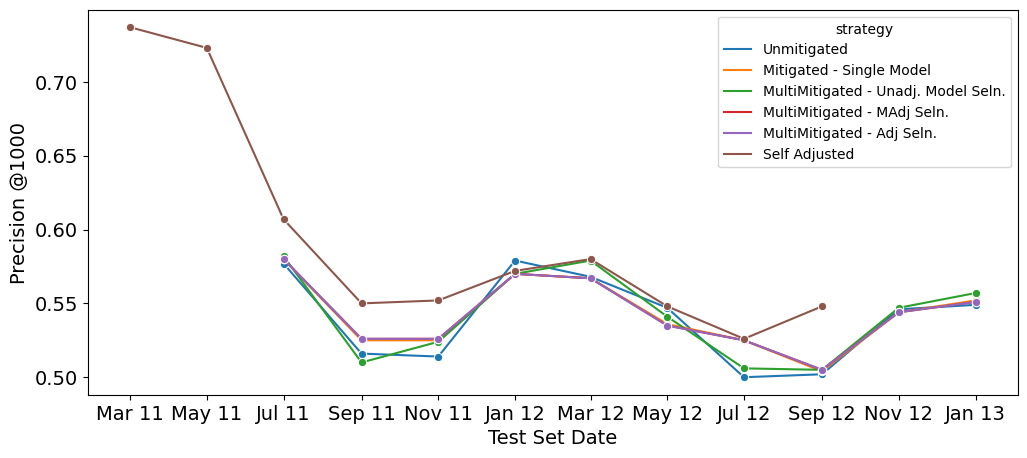

In [50]:
line_plot_over_time(y="value", y_label='Precision @1000', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

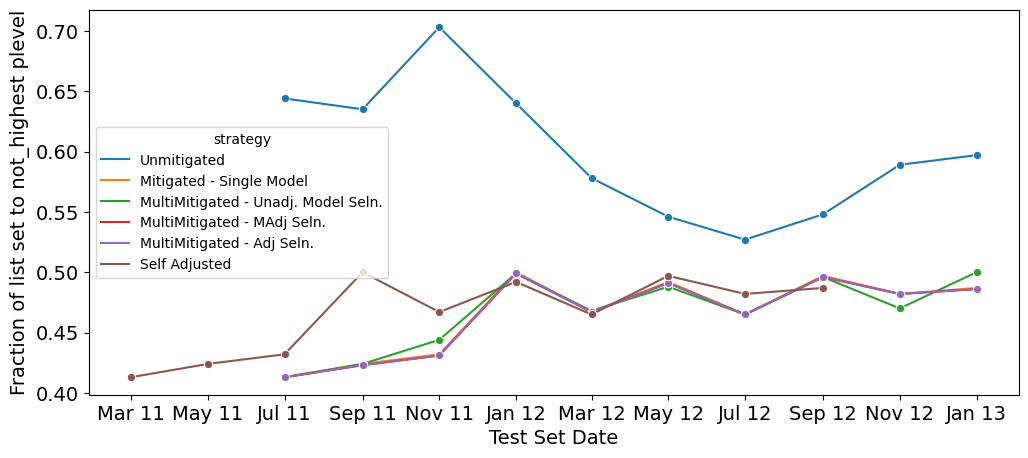

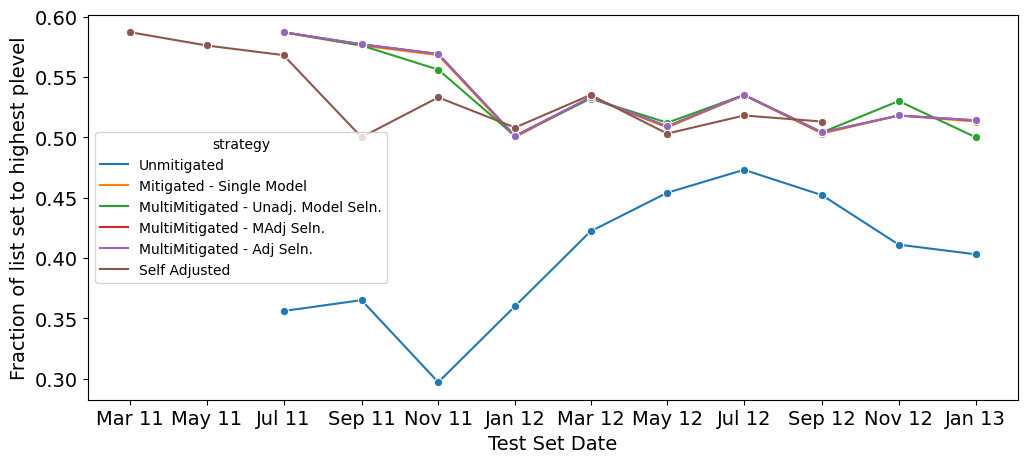

In [51]:
for cat in demo_values:
    line_plot_over_time(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

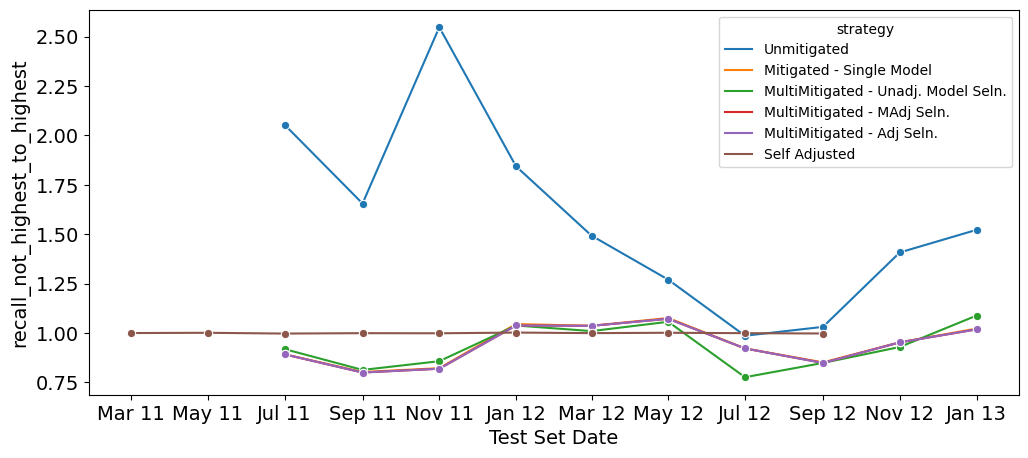

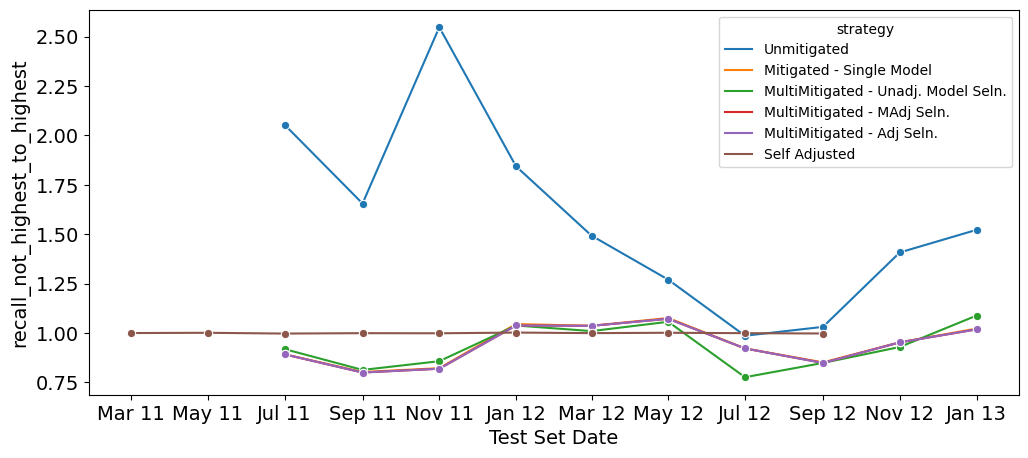

In [52]:
for setting in recall_combinations:
    line_plot_over_time(y=setting, y_label=setting, strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

# Reproducing the Bias Adjustments

The following code will re-run the bias analysis itself starting from the model results. Note that there is some randomness in the code (breaking ties between projects with the same score as well as breaking ties between models with the same performance on a given test set), so the results you get here may not be exactly identical to the results above, but should be statistically consistent with them.

**NOTE: Running all of the results here can take a fair amount of time (around 2-3 hours on a db.m5.2xlarge AWS RDS instance), so be sure to be working in a screen/tmux setting if running the notebook remotely!**

Currently, this code assumes your data is in a postgres database containing modeling results in the format of our open-source `triage` machine learning pipeline, including temporal validation splits.


Next, let's clear out anything in the `bias_results` schema (these should start empty, unless you've already run anything since loading the database):

In [1]:
from DJRecallAdjuster import ra_procedure

In [2]:
weights = [1, 0]

In [3]:
ra_procedure(weights=weights, pause_phases=False, small_model_selection=True)

[('2014-06-01', '2014-06-01'), ('2014-06-01', '2014-09-01')]
[('2014-09-01', '2014-09-01'), ('2014-09-01', '2014-12-01')]
[('2014-12-01', '2014-12-01'), ('2014-12-01', '2015-03-01')]
[('2015-03-01', '2015-03-01'), ('2015-03-01', '2015-06-01')]
[('2015-06-01', '2015-06-01'), ('2015-06-01', '2015-09-01')]
[('2015-09-01', '2015-09-01'), ('2015-09-01', '2015-12-01')]
[('2015-12-01', '2015-12-01'), ('2015-12-01', '2016-03-01')]
[('2016-03-01', '2016-03-01'), ('2016-03-01', '2016-04-01')]
